In [2]:
# Load all required Libraries

import re
import sys
import spacy
import torch
import pyLDAvis
import transformers
import numpy as np
import pandas as pd
from typing import List
from gensim import corpora
from ragas import evaluate
from datasets import Dataset
import pyLDAvis.gensim_models as gensimvis
from gensim.models.ldamodel import LdaModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from pymilvus import MilvusClient, FieldSchema, CollectionSchema, DataType
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from ragas.metrics import faithfulness, answer_relevancy, context_recall, context_precision


from collections import defaultdict
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Load the spaCy model
nlp = spacy.load("en_core_web_md")


/opt/anaconda3/envs/llm_env/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/llm_env/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/anaconda3/envs/llm_env/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/llm_env/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/llm_env/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/llm_env/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/llm_env/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `li

# Read Passages from the Datasets and Drop rows if they are NA or empty

In [4]:
# Load one Parquet shard from the Hugging Face Mini-Wikipedia RAG dataset
# into a pandas DataFrame. The 'hf://' scheme reads directly from HF Hub.
passages = pd.read_parquet(
    "hf://datasets/rag-datasets/rag-mini-wikipedia/data/passages.parquet/part.0.parquet",
    engine='fastparquet'
).reset_index()

print(passages.shape)

# Remove any row that contains at least one missing value in *any* column.
# Note: this can drop more rows than you expect if some metadata fields are sparsely populated.
passages = passages.dropna()

# Print a quick shape summary as (num_rows, num_columns).
print(passages.shape)

# Show the first five rows for a quick visual inspection (in notebooks this renders a table).
# In a pure Python script, use 'print(passages.head())' to actually see output in the console.
passages.head()

(3200, 2)
(3200, 2)


,id,passage
0,0,"Uruguay (official full name in ; pron. , Eas..."
1,1,"It is bordered by Brazil to the north, by Arge..."
2,2,Montevideo was founded by the Spanish in the e...
3,3,The economy is largely based in agriculture (m...
4,4,"According to Transparency International, Urugu..."


# Do EDA on the passage dataset
- You can try to find the maximum and minimum length of the passages before indexing (just a direction)

In [5]:
passages["passage_norm"] = passages["passage"].str.lower().str.replace(r"\s+", " ", regex=True)
passages["passage_norm"] = passages["passage_norm"].str.replace(r"[^a-z0-9 ]", "", regex=True)

In [6]:
print("Number of duplicate passages: ", passages["passage_norm"].duplicated(keep=False).mean()*len(passages))

passages = passages[~passages["passage_norm"].duplicated(keep=False)]

print("Number of unique documents: ", len(passages))

Number of duplicate passages:  16.0
Number of unique documents:  3184


count    3184.000000
mean      377.617776
std       336.431893
min         4.000000
25%       104.000000
50%       289.000000
75%       557.000000
max      2436.000000
Name: passage_norm, dtype: float64


<Axes: >

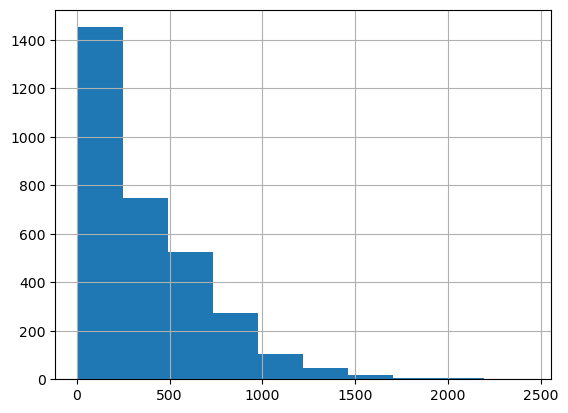

In [7]:
## Character distribution
print(passages['passage_norm'].apply(lambda x: len(x)).describe())
passages['passage_norm'].apply(lambda x: len(x)).hist()

In [8]:
def preprocess_spacy(texts: List[str]) -> List[List[str]]:
    """
    Tokenizes, lemmatizes, and filters tokens using spaCy.
    """
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=50):
        # Filter tokens:
        # 1. Is not a stop word
        # 2. Is not punctuation/whitespace/a digit
        # 3. Is alphabetic (optional, helps filter symbols/numbers)
        # 4. Length is greater than 2
        tokens = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop
            and not token.is_punct
            and not token.is_space
            and token.is_alpha
            and len(token) > 2
        ]
        processed_texts.append(tokens)
    return processed_texts

# Apply preprocessing
processed_docs = preprocess_spacy(passages['passage_norm'])

# Example output of one processed document
print("Example Processed Document:", processed_docs[0])
# Expected output: ['machine', 'learning', 'model', 'train', 'large', 'dataset', 'prediction', 'future', 'data']

Example Processed Document: ['uruguay', 'official', 'pron', 'eastern', 'republic', 'uruguay', 'country', 'locate', 'southeastern', 'south', 'america', 'home', 'million', 'people', 'million', 'live', 'capital', 'montevideo', 'metropolitan', 'area']


In [9]:
# Create a dictionary from the processed documents
# This maps every unique token to a unique ID
dictionary = corpora.Dictionary(processed_docs)

# Optional: Filter out words that appear in too few or too many documents
# e.g., keep tokens that appear in at least 2 documents and no more than 80% of documents
dictionary.filter_extremes(no_below=2, no_above=0.8)

In [10]:
# Convert the tokenized documents into a bag-of-words (BoW) format
# The format is [(token_id, count), ...]
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Example output of one document in BoW format
print("\nExample BoW Corpus Entry:", corpus[0][:3])
# Expected output: [(0, 1), (1, 1), (2, 1)] (ID, Count)


Example BoW Corpus Entry: [(0, 1), (1, 1), (2, 1)]


In [11]:
# Set the number of topics you want to extract
num_topics = 5

# Train the LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

print("\nTopics discovered by LDA:")
for idx, topic in lda_model.print_topics(num_words=20):
    print(f"Topic #{idx}: {topic}")

print("="*100)

print("\nDocument Topic Assignments:")
for i, doc in enumerate(corpus):
    # Get the topic distribution for the document
    topic_distribution = lda_model.get_document_topics(doc, minimum_probability=0.1)

    # Find the dominant topic (highest probability)
    dominant_topic = max(topic_distribution, key=lambda x: x[1]) if topic_distribution else (None, 0.0)

    print(f"Document {i}: Dominant Topic #{dominant_topic[0]} (Prob: {dominant_topic[1]:.2f})")
    print(f"  Original Text: {processed_docs[i][:60]}...")


Topics discovered by LDA:
Topic #0: 0.011*"law" + 0.010*"europe" + 0.010*"high" + 0.009*"economy" + 0.009*"force" + 0.008*"act" + 0.008*"qatar" + 0.008*"base" + 0.008*"union" + 0.008*"important" + 0.007*"empire" + 0.007*"good" + 0.007*"minister" + 0.006*"follow" + 0.006*"system" + 0.006*"study" + 0.006*"term" + 0.006*"bird" + 0.006*"play" + 0.005*"influence"
Topic #1: 0.029*"romania" + 0.020*"country" + 0.019*"singapore" + 0.015*"world" + 0.014*"large" + 0.011*"population" + 0.011*"area" + 0.010*"polar" + 0.009*"european" + 0.008*"include" + 0.008*"specie" + 0.008*"leopard" + 0.008*"beetle" + 0.007*"canada" + 0.006*"small" + 0.006*"people" + 0.006*"like" + 0.005*"water" + 0.005*"million" + 0.005*"romanian"
Topic #2: 0.046*"roosevelt" + 0.019*"president" + 0.016*"duck" + 0.015*"state" + 0.013*"new" + 0.013*"government" + 0.010*"party" + 0.010*"wilson" + 0.009*"theodore" + 0.009*"united" + 0.008*"york" + 0.008*"house" + 0.008*"states" + 0.008*"american" + 0.007*"international" + 0.007*"

In [12]:
# Create the visualization data
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Display the visualization
pyLDAvis.display(lda_display)

In [13]:
def extract_spacy_features(text):
    """Processes text with spaCy to extract Named Entities and POS counts."""
    if not isinstance(text, str):
        # Handle non-string values (e.g., if there are NaNs)
        return [], 0, {}

    doc = nlp(text)
    
    # 1. Named Entity Recognition (NER)
    # Extracts the entity text and its label (e.g., 'GPE', 'PERSON')
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # 2. Token Count (A useful basic feature)
    token_count = len(doc)
    
    # 3. Part-of-Speech (POS) Tag Counts (For deeper linguistic analysis)
    pos_counts = {}
    for token in doc:
        pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1
        
    return entities, token_count, pos_counts

# Apply the function to the text column of your DataFrame
# We only process a small sample for demonstration efficiency


passages[['entities', 'token_count', 'pos_counts']] = passages['passage'].apply(
    lambda x: pd.Series(extract_spacy_features(x))
)

print(f"Processed {len(passages)} passages and added spaCy features.")
print("\nFirst passage entities:")
print(passages.loc[0, 'entities'])
print("\nFirst passage POS counts:")
print(passages.loc[0, 'pos_counts'])

Processed 3184 passages and added spaCy features.

First passage entities:
[('Uruguay', 'GPE'), ('Eastern Republic', 'GPE'), ('Uruguay', 'GPE'), ('South America', 'LOC'), ('3.3 million', 'CARDINAL'), ('1.7 million', 'CARDINAL'), ('Montevideo', 'PERSON')]

First passage POS counts:
{'PROPN': 8, 'PUNCT': 8, 'ADJ': 4, 'NOUN': 7, 'ADP': 7, 'SPACE': 4, 'AUX': 2, 'DET': 3, 'VERB': 1, 'PRON': 3, 'NUM': 4, 'ADV': 1, 'CCONJ': 1}


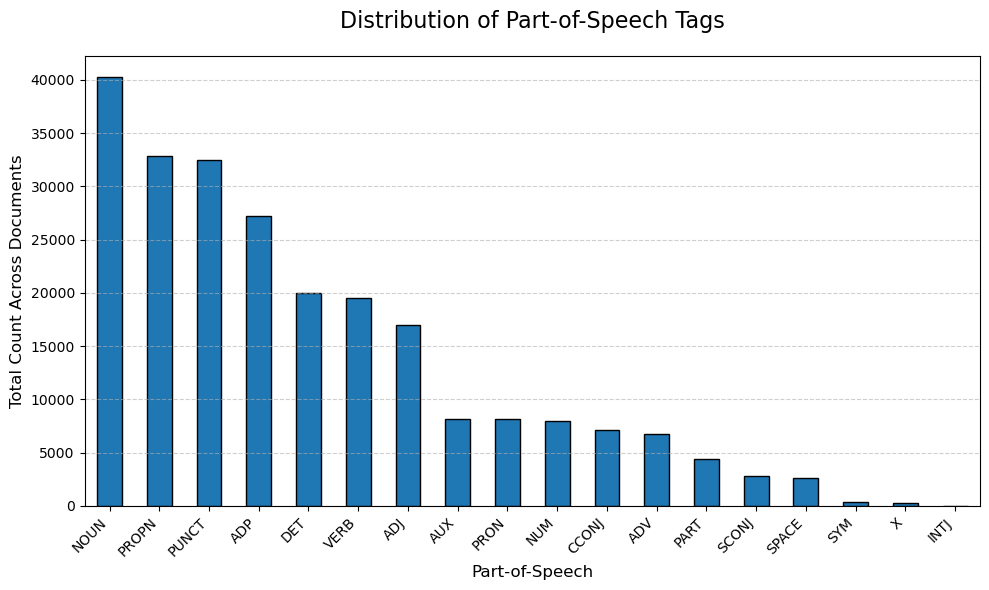

In [14]:
# Create an empty dictionary to hold the combined counts
total_pos_counts = defaultdict(int)

# Iterate through the 'pos_counts' column (which holds dictionaries)
for counts_dict in passages['pos_counts']:
    for pos_tag, count in counts_dict.items():
        total_pos_counts[pos_tag] += count

# Convert the resulting dictionary into a Pandas Series for easy plotting
pos_counts_series = pd.Series(total_pos_counts)

# Sort the counts for a cleaner visualization
pos_counts_sorted = pos_counts_series.sort_values(ascending=False)

# --- 3. Create the Bar Plot ---

plt.figure(figsize=(10, 6))
pos_counts_sorted.plot(
    kind='bar',
    color='#1f77b4', # A nice blue color
    edgecolor='black'
)

plt.title('Distribution of Part-of-Speech Tags', fontsize=16, pad=20)
plt.xlabel('Part-of-Speech', fontsize=12)
plt.ylabel('Total Count Across Documents', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels from being cut off

# Save the plot (optional, but good practice)
plt.savefig('pos_counts_bar_plot.png')

# Show the plot
plt.show()


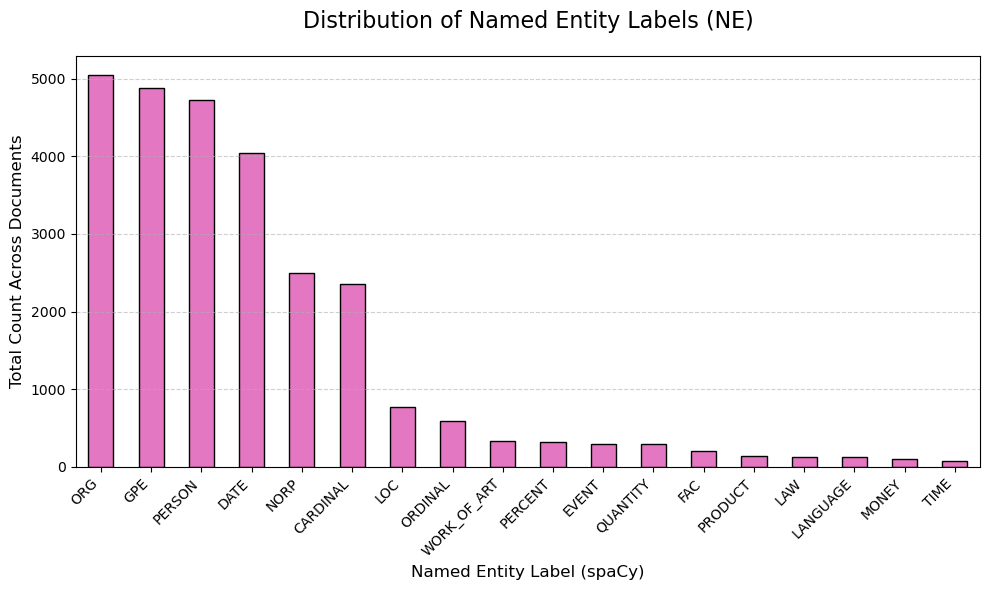

In [15]:
# Create an empty dictionary to hold the combined NE label counts
total_ne_counts = defaultdict(int)

# Iterate through the 'entities' column (which holds lists of (text, label) tuples)
for entities_list in passages['entities']:
    for text, label in entities_list:
        # Increment count for each entity label (e.g., 'GPE', 'DATE')
        total_ne_counts[label] += 1

ne_counts_series = pd.Series(total_ne_counts)

# Sort the counts for a cleaner visualization
ne_counts_sorted = ne_counts_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ne_counts_sorted.plot(
    kind='bar',
    color='#e377c2', # A nice pink/purple color for NEs
    edgecolor='black'
)

# Updated title and labels
plt.title('Distribution of Named Entity Labels (NE)', fontsize=16, pad=20)
plt.xlabel('Named Entity Label (spaCy)', fontsize=12)
plt.ylabel('Total Count Across Documents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot
plt.savefig('ne_counts_bar_plot.png')

# Show the plot
plt.show()

In [16]:
passages["char_len"]  = passages["passage"].str.len()
passages["word_len"]  = passages["passage"].str.split().str.len()

passages["non_ascii_pct"] = passages["passage"].apply(lambda s: sum(ord(c)>127 for c in s))/passages["char_len"]
passages["punct_pct"]     = passages["passage"].str.count(r"[^\w\s]")/passages["char_len"]
passages["digits_pct"]    = passages["passage"].str.count(r"\d")/passages["char_len"]
passages[["char_len","word_len", "token_count", "non_ascii_pct","punct_pct","digits_pct"]].describe()

,char_len,word_len,token_count,non_ascii_pct,punct_pct,digits_pct
count,3184.000000,3184.000000,3184.000000,3184.000000,3184.000000,3184.000000
mean,391.730842,62.400754,74.751570,0.002463,0.036769,0.022200
std,348.221040,55.401186,65.965153,0.012598,0.028954,0.040169
min,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,109.750000,17.750000,22.750000,0.000000,0.021505,0.000000
50%,301.500000,49.000000,58.000000,0.000000,0.029255,0.010435
75%,575.250000,92.000000,109.000000,0.000000,0.041272,0.029630
max,2515.000000,425.000000,500.000000,0.387097,0.428571,0.615385


<Axes: >

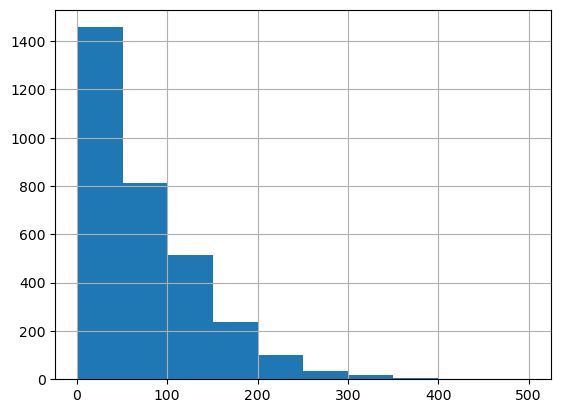

In [17]:
passages["token_count"].hist()

In [ ]:
passages  = passages[passages['token_count'] >= 3]

passages = passages[['id', 'passage']]

passages.to_csv('../data/processed/passages.csv', index=False)

passages.head()

,id,passage
0,0,"Uruguay (official full name in ; pron. , Eas..."
1,1,"It is bordered by Brazil to the north, by Arge..."
2,2,Montevideo was founded by the Spanish in the e...
3,3,The economy is largely based in agriculture (m...
4,4,"According to Transparency International, Urugu..."


# Tokenize Text and Generate Embeddings using Sentence Transformers

In [1]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode Text
#embeddings = ...

NameError: name 'SentenceTransformer' is not defined

# Create Milvus Client and Insert your Embeddings to your DB
- Make sure you define a schema for your collection (Points will be deducted if you fail to define a proper schema with ids, passage text, embedding)

In [ ]:
# Define every column of your schema

id_ = ...          
passage = ...              
embedding = ...         

In [ ]:
schema = ...

In [3]:
client = MilvusClient("rag_wikipedia_mini.db")

# Create the Collection with Collection Name = "rag_mini". Make sure you define the schema variable while creating the collection

**Convert your Pandas Dataframe to a list of dictionaries**
- The Dictionary at least have 3 keys [id, passage, embedding]

In [ ]:
rag_data = ...

In [ ]:
# Code to insert the data to your DB
res = client.insert(collection_name="rag_mini", data=rag_data)

print(res)

- Do a Sanity Check on your database 

**Do not delete the below line during your submission**

In [ ]:
print("Entity count:", client.get_collection_stats("rag_mini")["row_count"])
print("Collection schema:", client.describe_collection("rag_mini"))

# Steps to Fetch Results
- Read the Question Dataset
- Clean the Question Dataset if necessary (Drop Questions with NaN etc.)
- Convert Each Query to a Vector Embedding (Use the same embedding model you used to embed your document)
- Try for a Single Question First
- Load Collection into Memory after creating Index for Search on your embedding field (This is an essential step before you can search in your db)
- Search and Fetch Top N Results

In [ ]:
queries = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/test.parquet/part.0.parquet").reset_index()
queries.to_csv('../data/evaluation/test_dataset.csv', index = False)
queries.head()

,id,question,answer
0,0,Was Abraham Lincoln the sixteenth President of...,yes
1,2,Did Lincoln sign the National Banking Act of 1...,yes
2,4,Did his mother die of pneumonia?,no
3,6,How many long was Lincoln's formal education?,18 months
4,8,When did Lincoln begin his political career?,1832


In [ ]:
query = ...                 # Your single query

query_embedding = ...

print(query_embedding.shape)

#### Create Index on the embedding column on your DB

In [ ]:
index_params = MilvusClient.prepare_index_params()

# Add an index on the embedding field
...

# Create the index
try:
    ...
except Exception as e:
    print(f"Index creation result: {e}")

# Load collection into memory (required for search)
...
print("Collection loaded into memory")

In [ ]:
# Search the db with your query embedding
output_ = ...

print(output_)

## Now get the Context 
- Initially use the first passage ONLY as your context
- In Later Experiments, you must try at least 2 different passage selection strategies (Top 3 / Top 5 / Top 10) and pass to your prompt

In [ ]:
context = ...

**Develop your Prompt**

In [ ]:
system_prompt = f""

prompt = f"""{system_prompt} \n Context: {context}: \n Question: {query} """
print(prompt)

# RAG Response for a Single Query

In [ ]:
# Load the LLM Model you want to use
...

In [ ]:
# Generate answer
...

# Decode and extract answer.
...

# Generate Responses for all the Queries in the Dataset

In [ ]:
# Your Code Here
...

# Finding out the Basic QA Metrics (F1 score, EM score)

In [ ]:
# Your code Here
...

# Advanced Evaluation using RAGAs

In [ ]:
data = {
    "question": ... ,                     # Question
    "answer": ... ,                       # Generated Answer
    "contexts": ... ,                     # Context you pass in. You can just use top-1 here
    "ground_truths": ...                  # Reference Answer in the dataset (Human annotated)
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

In [ ]:
# Pass the dataset above to the evaluate method in RAGAs
# Your code here
...